In [45]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone.core.labels import Detection
from PIL import Image

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data

import torchvision
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn, MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import numpy as np

import os
import importlib
import sys
from pathlib import Path
from datetime import datetime

import utils
import train
from train import train_one_epoch, evaluate
import transforms as T

here = os.getcwd()
sys.path.append(os.path.join(here, '..'))
import DatasetLoaders
importlib.reload(DatasetLoaders)
from DatasetLoaders import HRSIDSegmentationDataset
import MaskRCNN_model_wrapper
from MaskRCNN_model_wrapper import MaskRCNNWrapper
import fiftyone_evaluation as fiftyone_evaluation
importlib.reload(MaskRCNN_model_wrapper)

<module 'MaskRCNN_model_wrapper' from '/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/MaskRCNN_model_wrapper.py'>

In [2]:
# get path to directory above
p = Path()
top_dir = p.absolute().parents[1]
top_dir

PosixPath('/home/k3vinli/ENEE439/Capstone')

In [38]:
name = "SSDD_train"
if name in fo.list_datasets():
    dataset_train = fo.load_dataset(name)
else:
    dataset_path = top_dir / "Datasets" / "Official-SSDD-OPEN" / "BBox_RBox_PSeg_SSDD" / "coco_style" / "images" / "train"
    labels_path = top_dir / "Datasets" / "Official-SSDD-OPEN" / "BBox_RBox_PSeg_SSDD" / "coco_style" / "annotations" / "train.json"
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_train = fo.Dataset.from_dir(
        data_path=dataset_path,
        labels_path=labels_path,
        dataset_type=dataset_type,
        name=name
    )

In [12]:
# dataset_train.delete()

In [39]:
name = "SSDD_test"
if name in fo.list_datasets():
    dataset_test = fo.load_dataset(name)
else:
    dataset_path = top_dir / "Datasets" / "Official-SSDD-OPEN" / "BBox_RBox_PSeg_SSDD" / "coco_style" / "images" / "test"
    labels_path = top_dir / "Datasets" / "Official-SSDD-OPEN" / "BBox_RBox_PSeg_SSDD" / "coco_style" / "annotations" / "test.json"
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_test = fo.Dataset.from_dir(
        data_path=dataset_path,
        labels_path=labels_path,
        dataset_type=dataset_type,
        name=name
    )

In [15]:
# dataset_test.delete()

In [17]:
dataset_train.compute_metadata()
dataset_test.compute_metadata()

In [18]:
paths = dataset_train.values("filepath")
sample = dataset_train[paths[1]]
sample.metadata

<ImageMetadata: {
    'size_bytes': None,
    'mime_type': None,
    'width': 500,
    'height': 403,
    'num_channels': None,
}>

In [61]:
dataset_test.values("predictions")

[<Detections: {
     'detections': [
         <Detection: {
             'id': '6462dba4b966945001a92805',
             'attributes': {},
             'tags': [],
             'label': 'ship',
             'bounding_box': [
                 0.5284777054419885,
                 0.15666804594152114,
                 0.10442950175358699,
                 0.2939172042043586,
             ],
             'mask': array([[False, False, False, ..., False, False, False],
                    [False, False, False, ..., False, False, False],
                    [False, False, False, ..., False, False, False],
                    ...,
                    [False, False, False, ..., False, False, False],
                    [False, False, False, ..., False, False, False],
                    [False, False, False, ..., False, False, False]]),
             'confidence': 0.9999861717224121,
             'index': None,
             'eval': 'tp',
             'eval_id': '64621a55b966945001a84d90',
       


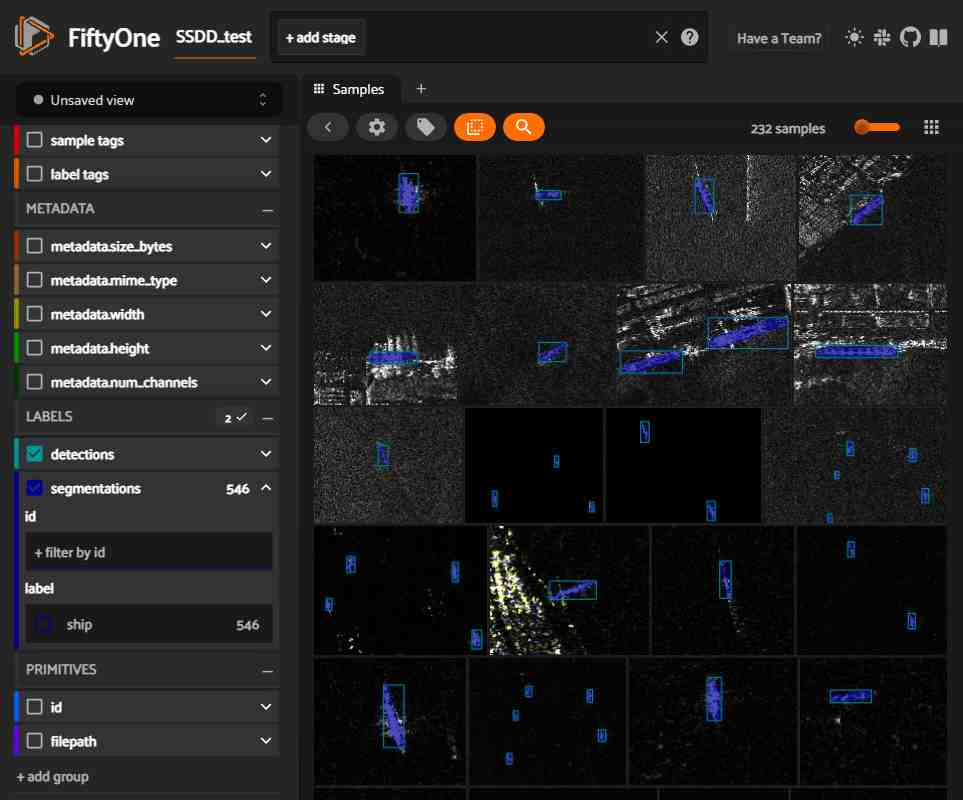

In [20]:
session = fo.launch_app()

In [28]:
maskrcnn = MaskRCNNWrapper(2, True)

In [34]:
def get_transform():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    
    return T.Compose(transforms)

In [40]:
SSDD_train = HRSIDSegmentationDataset(dataset_train, transforms=get_transform())
SSDD_test = HRSIDSegmentationDataset(dataset_test, transforms=get_transform())

In [41]:
def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4, print_freq=10):
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=4, shuffle=False, num_workers=8,
        collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=2, shuffle=False, num_workers=8,
        collate_fn=utils.collate_fn
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.5, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=20,
                                                    gamma=0.1)
    for epoch in range(num_epochs):
        train_one_epoch(model=model,
                        optimizer=optimizer, 
                        data_loader=data_loader,
                        device=device, 
                        epoch=epoch, 
                        print_freq=print_freq)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        lr_scheduler.step()
        evaluate(model=model, data_loader=data_loader_test, device=device)

In [43]:
do_training(maskrcnn.model, SSDD_train, SSDD_test, num_epochs=100)

Using cuda


/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)
/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)
/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely s

Epoch: [0]  [  0/232]  eta: 0:05:58  lr: 0.000027  loss: 0.4993 (0.4993)  loss_classifier: 0.0828 (0.0828)  loss_box_reg: 0.1427 (0.1427)  loss_mask: 0.2679 (0.2679)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.5469  data: 0.5763  max mem: 5698
Epoch: [0]  [ 10/232]  eta: 0:03:01  lr: 0.000243  loss: 0.6449 (0.6455)  loss_classifier: 0.1077 (0.1153)  loss_box_reg: 0.1627 (0.1503)  loss_mask: 0.3734 (0.3497)  loss_objectness: 0.0181 (0.0171)  loss_rpn_box_reg: 0.0128 (0.0130)  time: 0.8186  data: 0.0647  max mem: 5698
Epoch: [0]  [ 20/232]  eta: 0:03:46  lr: 0.000459  loss: 0.5950 (0.6076)  loss_classifier: 0.1077 (0.1100)  loss_box_reg: 0.1627 (0.1546)  loss_mask: 0.3016 (0.3229)  loss_objectness: 0.0045 (0.0114)  loss_rpn_box_reg: 0.0051 (0.0087)  time: 1.0420  data: 0.0144  max mem: 5698
Epoch: [0]  [ 30/232]  eta: 0:04:03  lr: 0.000675  loss: 0.5950 (0.6210)  loss_classifier: 0.1090 (0.1102)  loss_box_reg: 0.2100 (0.1887)  loss_mask: 0.2750 (0.3065) 

/home/k3vinli/ENEE439/Capstone/models/mask_rcnn/../DatasetLoaders.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks=torch.as_tensor(masks, dtype=torch.uint8)


creating index...
index created!
Test:  [  0/116]  eta: 0:01:43  model_time: 0.4781 (0.4781)  evaluator_time: 0.0081 (0.0081)  time: 0.8888  data: 0.4006  max mem: 5847
Test:  [100/116]  eta: 0:00:03  model_time: 0.1550 (0.1763)  evaluator_time: 0.0043 (0.0090)  time: 0.1703  data: 0.0074  max mem: 5847
Test:  [115/116]  eta: 0:00:00  model_time: 0.1802 (0.1782)  evaluator_time: 0.0158 (0.0105)  time: 0.2067  data: 0.0073  max mem: 5847
Test: Total time: 0:00:23 (0.2007 s / it)
Averaged stats: model_time: 0.1802 (0.1782)  evaluator_time: 0.0158 (0.0105)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.520
 

In [46]:
fiftyone_evaluation.add_detections(maskrcnn.model, SSDD_test, dataset_test, field_name="predictions")

Using device cuda
 100% |█████████████████| 232/232 [56.0s elapsed, 0s remaining, 2.8 samples/s]      


In [47]:
results = fo.evaluate_detections(
    dataset_test, 
    "predictions", 
    classes=["ship"],
    eval_key="eval", 
    compute_mAP=True,
    gt_field='detections'
)

Evaluating detections...
 100% |█████████████████| 232/232 [1.4s elapsed, 0s remaining, 160.3 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 232/232 [1.2s elapsed, 0s remaining, 199.6 samples/s]         


In [48]:
results.mAP()

0.7073413154061292

In [49]:
results.print_report()

              precision    recall  f1-score   support

        ship       0.83      0.97      0.89       546

   micro avg       0.83      0.97      0.89       546
   macro avg       0.83      0.97      0.89       546
weighted avg       0.83      0.97      0.89       546




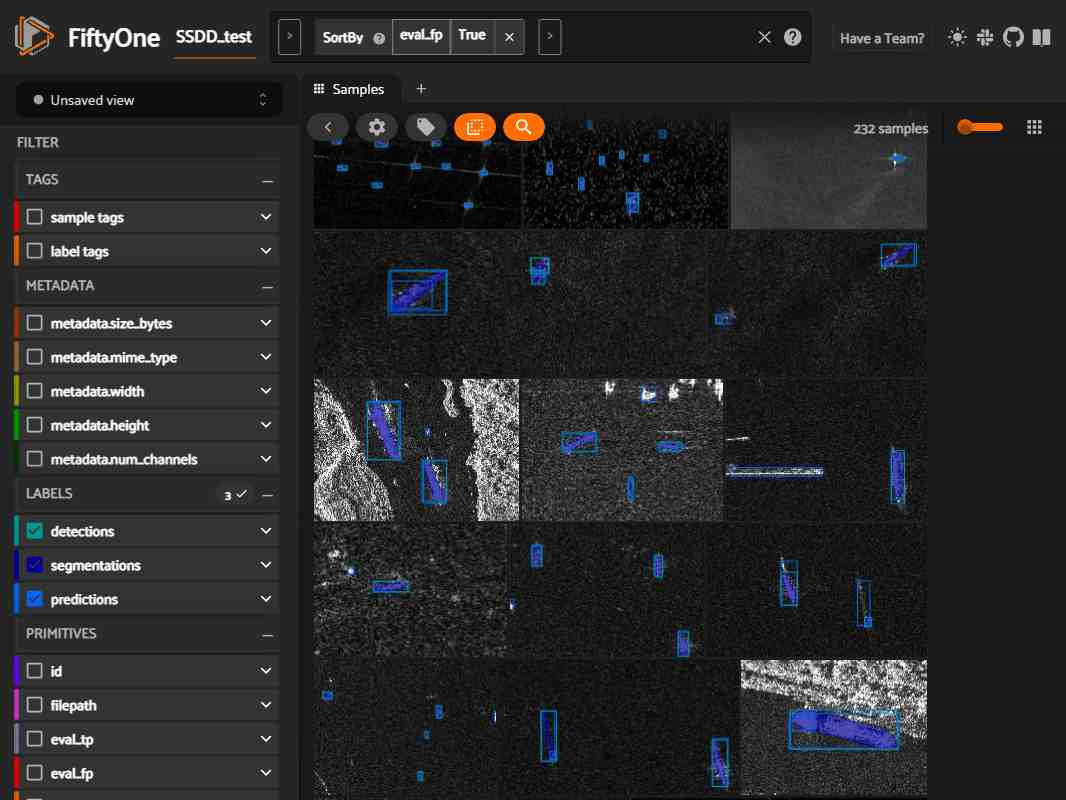

In [51]:
session.view = dataset_test.sort_by("eval_fp", reverse=True)

In [52]:
maskrcnn.save_model("maskrcnn_ssdd_pre_e100_lr001_m5_step20")